In [1]:
# Import libraries
import numpy as np    #for numerical, arrays, vectorized maths
import pandas as pd   # read csv and preprocessing
import matplotlib.pyplot as plt  # for plotting

In [2]:
# load data (power traces)
traceFilePath="../data/aes_power_tracesNew_28_07_2025_100k.csv"


In [3]:

# count power traces
total_traces = 0
with open(traceFilePath, 'r') as f:
    next(f)  # Removed first row (data cleaning)
    for line in f:
        total_traces += 1
print("Total traces (D):", total_traces)
D=total_traces

# Analysing Data set structure 
traceFile = pd.read_csv(traceFilePath, header=None, skiprows=1, nrows=10)
total_cols = traceFile.shape[1]
N = total_cols - 2
print (" Column 0: Plain text, column 1: Cipher text, col 2-1248 samples per trace")
print("Number of power samples per trace (N):", N)
print("D",total_traces,"N=",N)
print(traceFile[0])




Total traces (D): 100000
 Column 0: Plain text, column 1: Cipher text, col 2-1248 samples per trace
Number of power samples per trace (N): 1249
D 100000 N= 1249
0    3f38089bd859cc34325ef61310414049
1    52208e09f90d470b4fa4bb133e553c5e
2    9be480bbb2f87ff871aba813f97fc7c5
3    921328d07dcc637fa044e2237da763a5
4    2ff5de184295725859012611e9c1cdce
5    5ff27537f8687bbbe28e9a858da8a195
6    ec842bea7ccd73d0a504a5940210ffc8
7    b725115bd16e7ec6c9b0785ba10c3023
8    f327b6cf7d2540584dbf70d04cf08dea
9    d07d2e525e736d1c182192fc097395aa
Name: 0, dtype: object


In [4]:
import numpy as np

# AES inverse S-box (0-255)
inv_sbox = np.array([
    0x52,0x09,0x6a,0xd5,0x30,0x36,0xa5,0x38,0xbf,0x40,0xa3,0x9e,0x81,0xf3,0xd7,0xfb,
    0x7c,0xe3,0x39,0x82,0x9b,0x2f,0xff,0x87,0x34,0x8e,0x43,0x44,0xc4,0xde,0xe9,0xcb,
    0x54,0x7b,0x94,0x32,0xa6,0xc2,0x23,0x3d,0xee,0x4c,0x95,0x0b,0x42,0xfa,0xc3,0x4e,
    0x08,0x2e,0xa1,0x66,0x28,0xd9,0x24,0xb2,0x76,0x5b,0xa2,0x49,0x6d,0x8b,0xd1,0x25,
    0x72,0xf8,0xf6,0x64,0x86,0x68,0x98,0x16,0xd4,0xa4,0x5c,0xcc,0x5d,0x65,0xb6,0x92,
    0x6c,0x70,0x48,0x50,0xfd,0xed,0xb9,0xda,0x5e,0x15,0x46,0x57,0xa7,0x8d,0x9d,0x84,
    0x90,0xd8,0xab,0x00,0x8c,0xbc,0xd3,0x0a,0xf7,0xe4,0x58,0x05,0xb8,0xb3,0x45,0x06,
    0xd0,0x2c,0x1e,0x8f,0xca,0x3f,0x0f,0x02,0xc1,0xaf,0xbd,0x03,0x01,0x13,0x8a,0x6b,
    0x3a,0x91,0x11,0x41,0x4f,0x67,0xdc,0xea,0x97,0xf2,0xcf,0xce,0xf0,0xb4,0xe6,0x73,
    0x96,0xac,0x74,0x22,0xe7,0xad,0x35,0x85,0xe2,0xf9,0x37,0xe8,0x1c,0x75,0xdf,0x6e,
    0x47,0xf1,0x1a,0x71,0x1d,0x29,0xc5,0x89,0x6f,0xb7,0x62,0x0e,0xaa,0x18,0xbe,0x1b,
    0xfc,0x56,0x3e,0x4b,0xc6,0xd2,0x79,0x20,0x9a,0xdb,0xc0,0xfe,0x78,0xcd,0x5a,0xf4,
    0x1f,0xdd,0xa8,0x33,0x88,0x07,0xc7,0x31,0xb1,0x12,0x10,0x59,0x27,0x80,0xec,0x5f,
    0x60,0x51,0x7f,0xa9,0x19,0xb5,0x4a,0x0d,0x2d,0xe5,0x7a,0x9f,0x93,0xc9,0x9c,0xef,
    0xa0,0xe0,0x3b,0x4d,0xae,0x2a,0xf5,0xb0,0xc8,0xeb,0xbb,0x3c,0x83,0x53,0x99,0x61,
    0x17,0x2b,0x04,0x7e,0xba,0x77,0xd6,0x26,0xe1,0x69,0x14,0x63,0x55,0x21,0x0c,0x7d
], dtype=np.uint8)

# Compute Hamming weight lookup table for 0-255
hw_table = np.unpackbits(np.arange(256, dtype=np.uint8)[:, None], axis=1).sum(axis=1)


In [5]:
# Building H Matrix
def build_H(c_bytes, usedD, s_bytes=None, model="HW"):
    G = 256
    key_guesses = np.arange(G, dtype=np.uint8)  # for all 256 possible keys

    # Cypher text byte ⊕ Guessed key byte (C ⊕ K)
    xor_vals = c_bytes[:, np.newaxis] ^ key_guesses[np.newaxis, :]

    if model == "HW":
        # Apply inverse S-box
        V = inv_sbox[xor_vals]
    elif model == "HD":
        if s_bytes is None:
            raise ValueError("s_bytes must be provided for HD model")
        # Compute HD: C ⊕ S⁻¹(C ⊕ K)
        V = s_bytes[:, np.newaxis] ^ inv_sbox[xor_vals]
    else:
        raise ValueError("Unknown model. Choose 'HW' or 'HD'")

    # Compute Hamming weight using lookup table
    H = hw_table[V]  # shape (usedD, 256)
    
    return H


In [6]:

def run_cpa(H, T):
   
    # Get the number of traces (M)
    num_traces = H.shape[0]

    # DOM calculation (subtract the mean from each column) 
   
    H_centered = H - H.mean(axis=0, keepdims=True)
    T_centered = T - T.mean(axis=0, keepdims=True)

    # Calculate numerator of the Pearson formula 
    
    numerator = H_centered.T @ T_centered     

    # Calculate the corrected denominator:product of the L2 norm of each centered vector
    
    norm_H = np.sqrt(np.sum(H_centered**2, axis=0))[:, None] # Shape: (256, 1)
    norm_T = np.sqrt(np.sum(T_centered**2, axis=0))[None, :] # Shape: (1, N)
    denominator = norm_H * norm_T

    # Exception handling : division by zero
    
    denominator[denominator == 0] = 1

    # final correlation matrix 
    corr_matrix = numerator / denominator

    # best key guess : find the maximum absolute correlation value for each row
    
    max_corr = np.max(np.abs(corr_matrix), axis=1)    

    # The best guess is the one with the highest peak correlation.
    guess_max = np.argmax(max_corr)   

    return guess_max, corr_matrix

In [7]:
# Step 3: Load dataset 
usedD=100000
traceFile =pd.read_csv(traceFilePath,header=None,skiprows=1, nrows=usedD) # header=None to avoid panda to use first row as column identity
T = traceFile.iloc[:, 2:].to_numpy(dtype=np.float32)


In [ ]:

cipherTexts=traceFile[1]
target_byte =10


# AES inverse shift rows mapping for target byte 10
inv_shift = [0,5,10,15,4,9,14,3,8,13,2,7,12,1,6,11]

shifted_index = inv_shift[target_byte]  # Should extract from position for byte 10

# Extract the correct byte position (byte 10 = positions 20:22)
c_bytes = traceFile[1].apply(lambda x: int(x[2*target_byte:2*target_byte+2], 16)).to_numpy(dtype=np.uint8)

# Shift row operation
shifted_byte = inv_shift[target_byte]
s_bytes = traceFile[1].apply(lambda x: int(x[2*shifted_byte:2*shifted_byte+2], 16)).to_numpy(dtype=np.uint8)



# HD Model
H_hd = build_H(c_bytes, usedD, s_bytes,model="HD")
guess_hd,  corr_hd = run_cpa(H_hd, T)





# Compute maximum correlation value 
max_corr_hd = np.max(np.abs(corr_hd))



print(f"Byte {target_byte:2d}: HD guess = {guess_hd:3d} (0x{guess_hd:02X})")
print(f"HD → max |corr| = {max_corr_hd:.4f}")

# Result is:
# Byte 10: HD guess = 192 (0xC0)
# HD → max |corr| = 0.0320



Byte 10: HD guess = 192 (0xC0)
HD → max |corr| = 0.0320


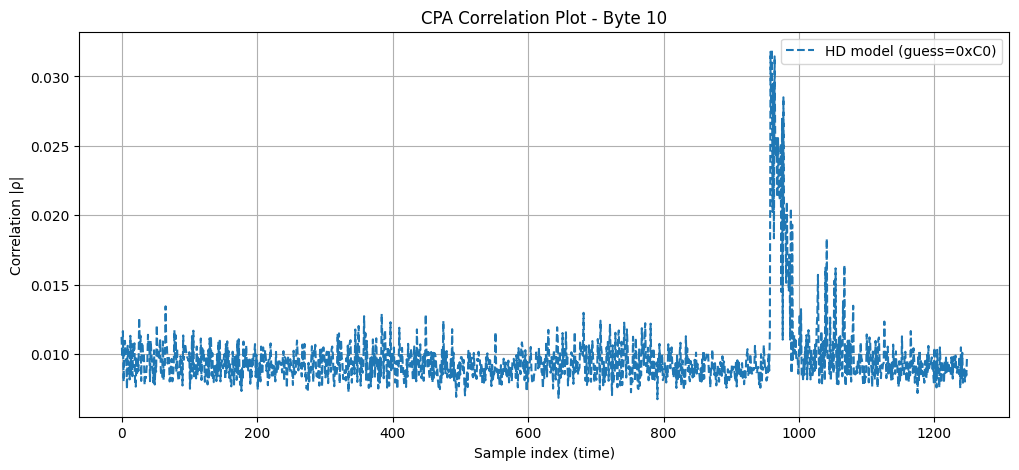

In [12]:
# Plot correlation traces for both models
plt.figure(figsize=(12,5))
plt.plot(np.max(np.abs(corr_hd), axis=0), label=f'HD model (guess=0x{guess_hd:02X})', linestyle='--')
plt.xlabel("Sample index (time)")
plt.ylabel("Correlation |ρ|")
plt.title(f"CPA Correlation Plot - Byte {target_byte}")
plt.legend()
plt.grid(True)
plt.show()

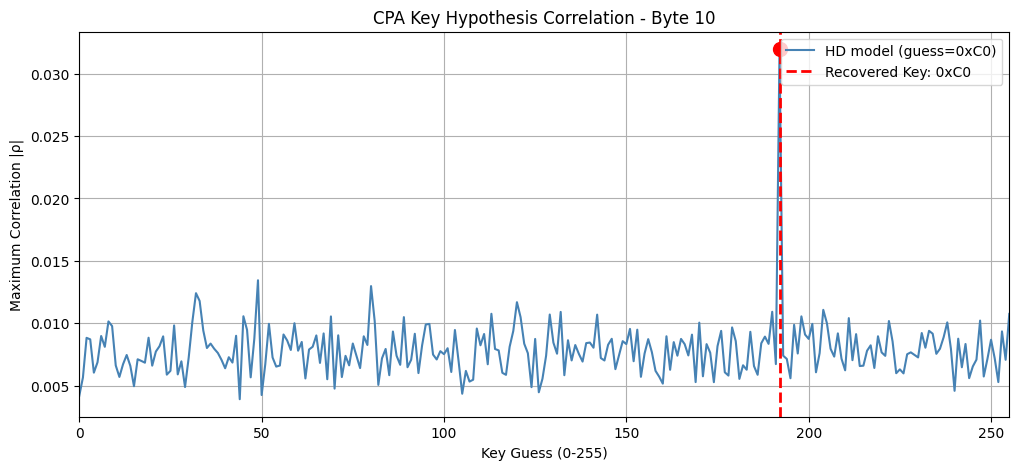

In [13]:
# Extract maximum absolute correlation for each key guess
max_corr_per_key = np.max(np.abs(corr_hd), axis=1)

# Plot key guess vs correlation
plt.figure(figsize=(12,5))
plt.plot(max_corr_per_key, label=f'HD model (guess=0x{guess_hd:02X})', color='steelblue')
plt.axvline(x=guess_hd, color='red', linestyle='--', linewidth=2, label=f'Recovered Key: 0x{guess_hd:02X}')
plt.scatter(guess_hd, max_corr_per_key[guess_hd], color='red', s=100, zorder=5)
plt.xlabel("Key Guess (0-255)")
plt.ylabel("Maximum Correlation |ρ|")
plt.title(f"CPA Key Hypothesis Correlation - Byte {target_byte}")
plt.legend()
plt.grid(True)
plt.xlim([0, 255])
plt.show()
